In [3]:
from transformers import AutoTokenizer, AutoModel, utils
from bertviz import head_view, model_view

import torch
import numpy as np

from util.model import load_model, get_device_memory_report
from util.data import load_grammar_data, load_hidden_data
from util.model import clear_cuda_cache, get_device_memory_report

from tqdm import tqdm

import os
import gc

In [4]:
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
get_device_memory_report(device)

Device: cuda:7 [NVIDIA RTX 6000 Ada Generation]
Free Memory: 47.08/47.50 GB [99.11%]


In [11]:
import numpy as np

def kl_divergence(p, q):
    return np.sum(p * np.log(p / q))

def jensen_shannon_divergence(p, q):
    m = (p + q) / 2

    p = p[m > 0]
    q = q[m > 0]
    m = m[m > 0]
    
    return (kl_divergence(p, m) + kl_divergence(q, m)) / 2

def jensen_shannon_divergence_2D(P, Q):
    D = np.zeros(P.shape[0])
    for i in range(P.shape[0]):
        D[i] = jensen_shannon_divergence(P[i], Q[i])
    return D.mean(axis=0)

def entropy(P):
    P = P[P > 0]
    return -np.sum(P * np.log(P))

def entropy_divergence(P, Q, last_layer_only=True):
    D = np.zeros(P.shape[0])
    for i in range(P.shape[0]):
        D[i] = entropy(P[i]) - entropy(Q[i])
    return D.mean(axis=0)


def total_variation_distance(P, Q, last_layer_only=True):
    if last_layer_only:
        return np.abs(P[-1] - Q[-1]).mean()

    return np.sum(np.abs(P - Q), axis=1).mean()

def cosine_similarity(p, q):
    return 1 - np.dot(p, q) / (np.linalg.norm(p) * np.linalg.norm(q))

def euclidean_distance(p, q):
    return np.linalg.norm(p - q)

def frobenius_norm(P, Q):
    return np.linalg.norm(P - Q, 'fro')

def manhattan_distance(p, q):
    return np.sum(np.abs(p - q))


In [12]:
from sklearn.preprocessing import MinMaxScaler

def get_divergences(good_attentions, bad_attentions, dist_func=jensen_shannon_divergence):

    divergences = np.zeros((len(good_attentions), good_attentions[0].shape[0], good_attentions[0].shape[1]))
    for i, (good_attention, bad_attention) in tqdm(enumerate(zip(good_attentions, bad_attentions))):
        for n_layer in range(good_attention.shape[0]):
            for n_head in range(good_attention.shape[1]):
                good_attention_dist = good_attention[n_layer, n_head]
                bad_attention_dist = bad_attention[n_layer, n_head]
                divergences[i, n_layer, n_head] = dist_func(good_attention_dist, bad_attention_dist)
    return np.array(divergences)

def get_normalized_divergences(good_attentions, bad_attentions, dist_func=jensen_shannon_divergence, normalize=True):
    divergences = get_divergences(good_attentions, bad_attentions, dist_func)
    divergences = divergences.mean(axis=0)
    if normalize:
        divergences = MinMaxScaler().fit_transform(divergences)
    return divergences

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def create_divergence_heatmap(matrix, method_name='Jensen-Shannon Divergence'):
    plt.figure(figsize=(matrix.shape[1], matrix.shape[0] * .8))
    sns.heatmap(matrix, annot=True, cmap='viridis', vmin=0, vmax=1)
    plt.title(f'Mean Attention Divergences | {method_name} ')
    plt.xlabel('Head')
    plt.ylabel('Layer')
    plt.tight_layout()
    
    plt.show()

In [14]:
def plot_attention_divergences(model_name, grammar_name, dist_func=jensen_shannon_divergence, normalize=True):
    hidden_data = load_hidden_data(model_name, grammar_name)
    good_attentions, bad_attentions = (
        [example['good_attention_states'] for example in hidden_data],
        [example['bad_attention_states'] for example in hidden_data]
    )
    divergences = get_normalized_divergences(good_attentions, bad_attentions, dist_func, normalize)
    create_divergence_heatmap(divergences, f'{model_name} | {grammar_name} | {dist_func.__name__}')
    clear_cuda_cache()

1000it [00:03, 330.21it/s]


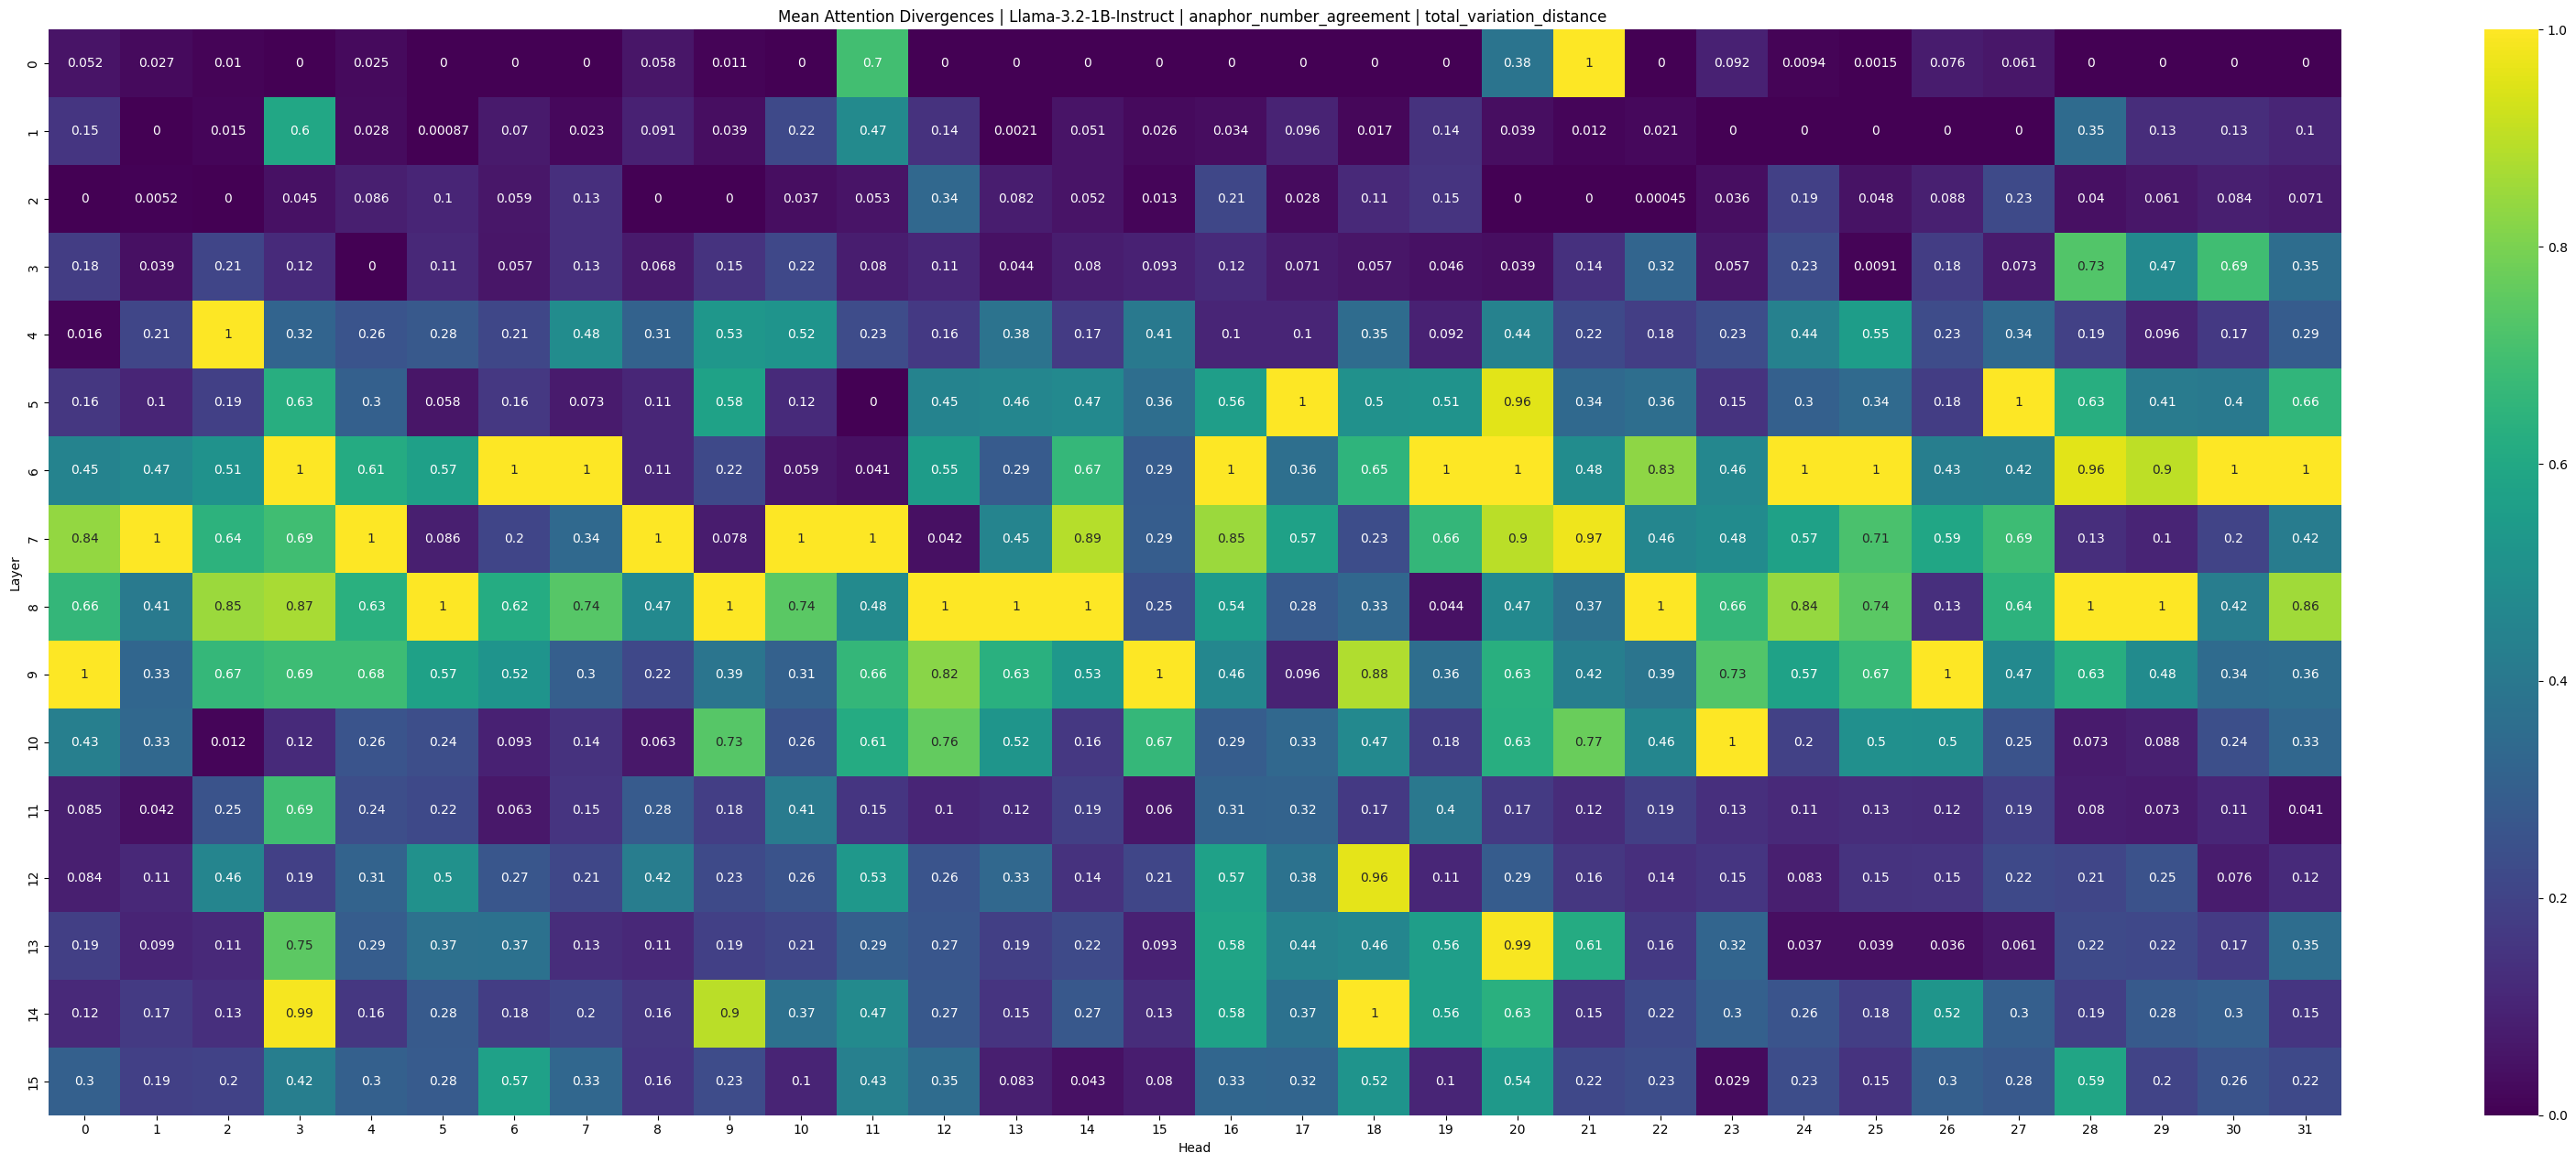

In [15]:
plot_attention_divergences('Llama-3.2-1B-Instruct', 'anaphor_number_agreement', dist_func=total_variation_distance, normalize=True)

1000it [00:04, 246.36it/s]


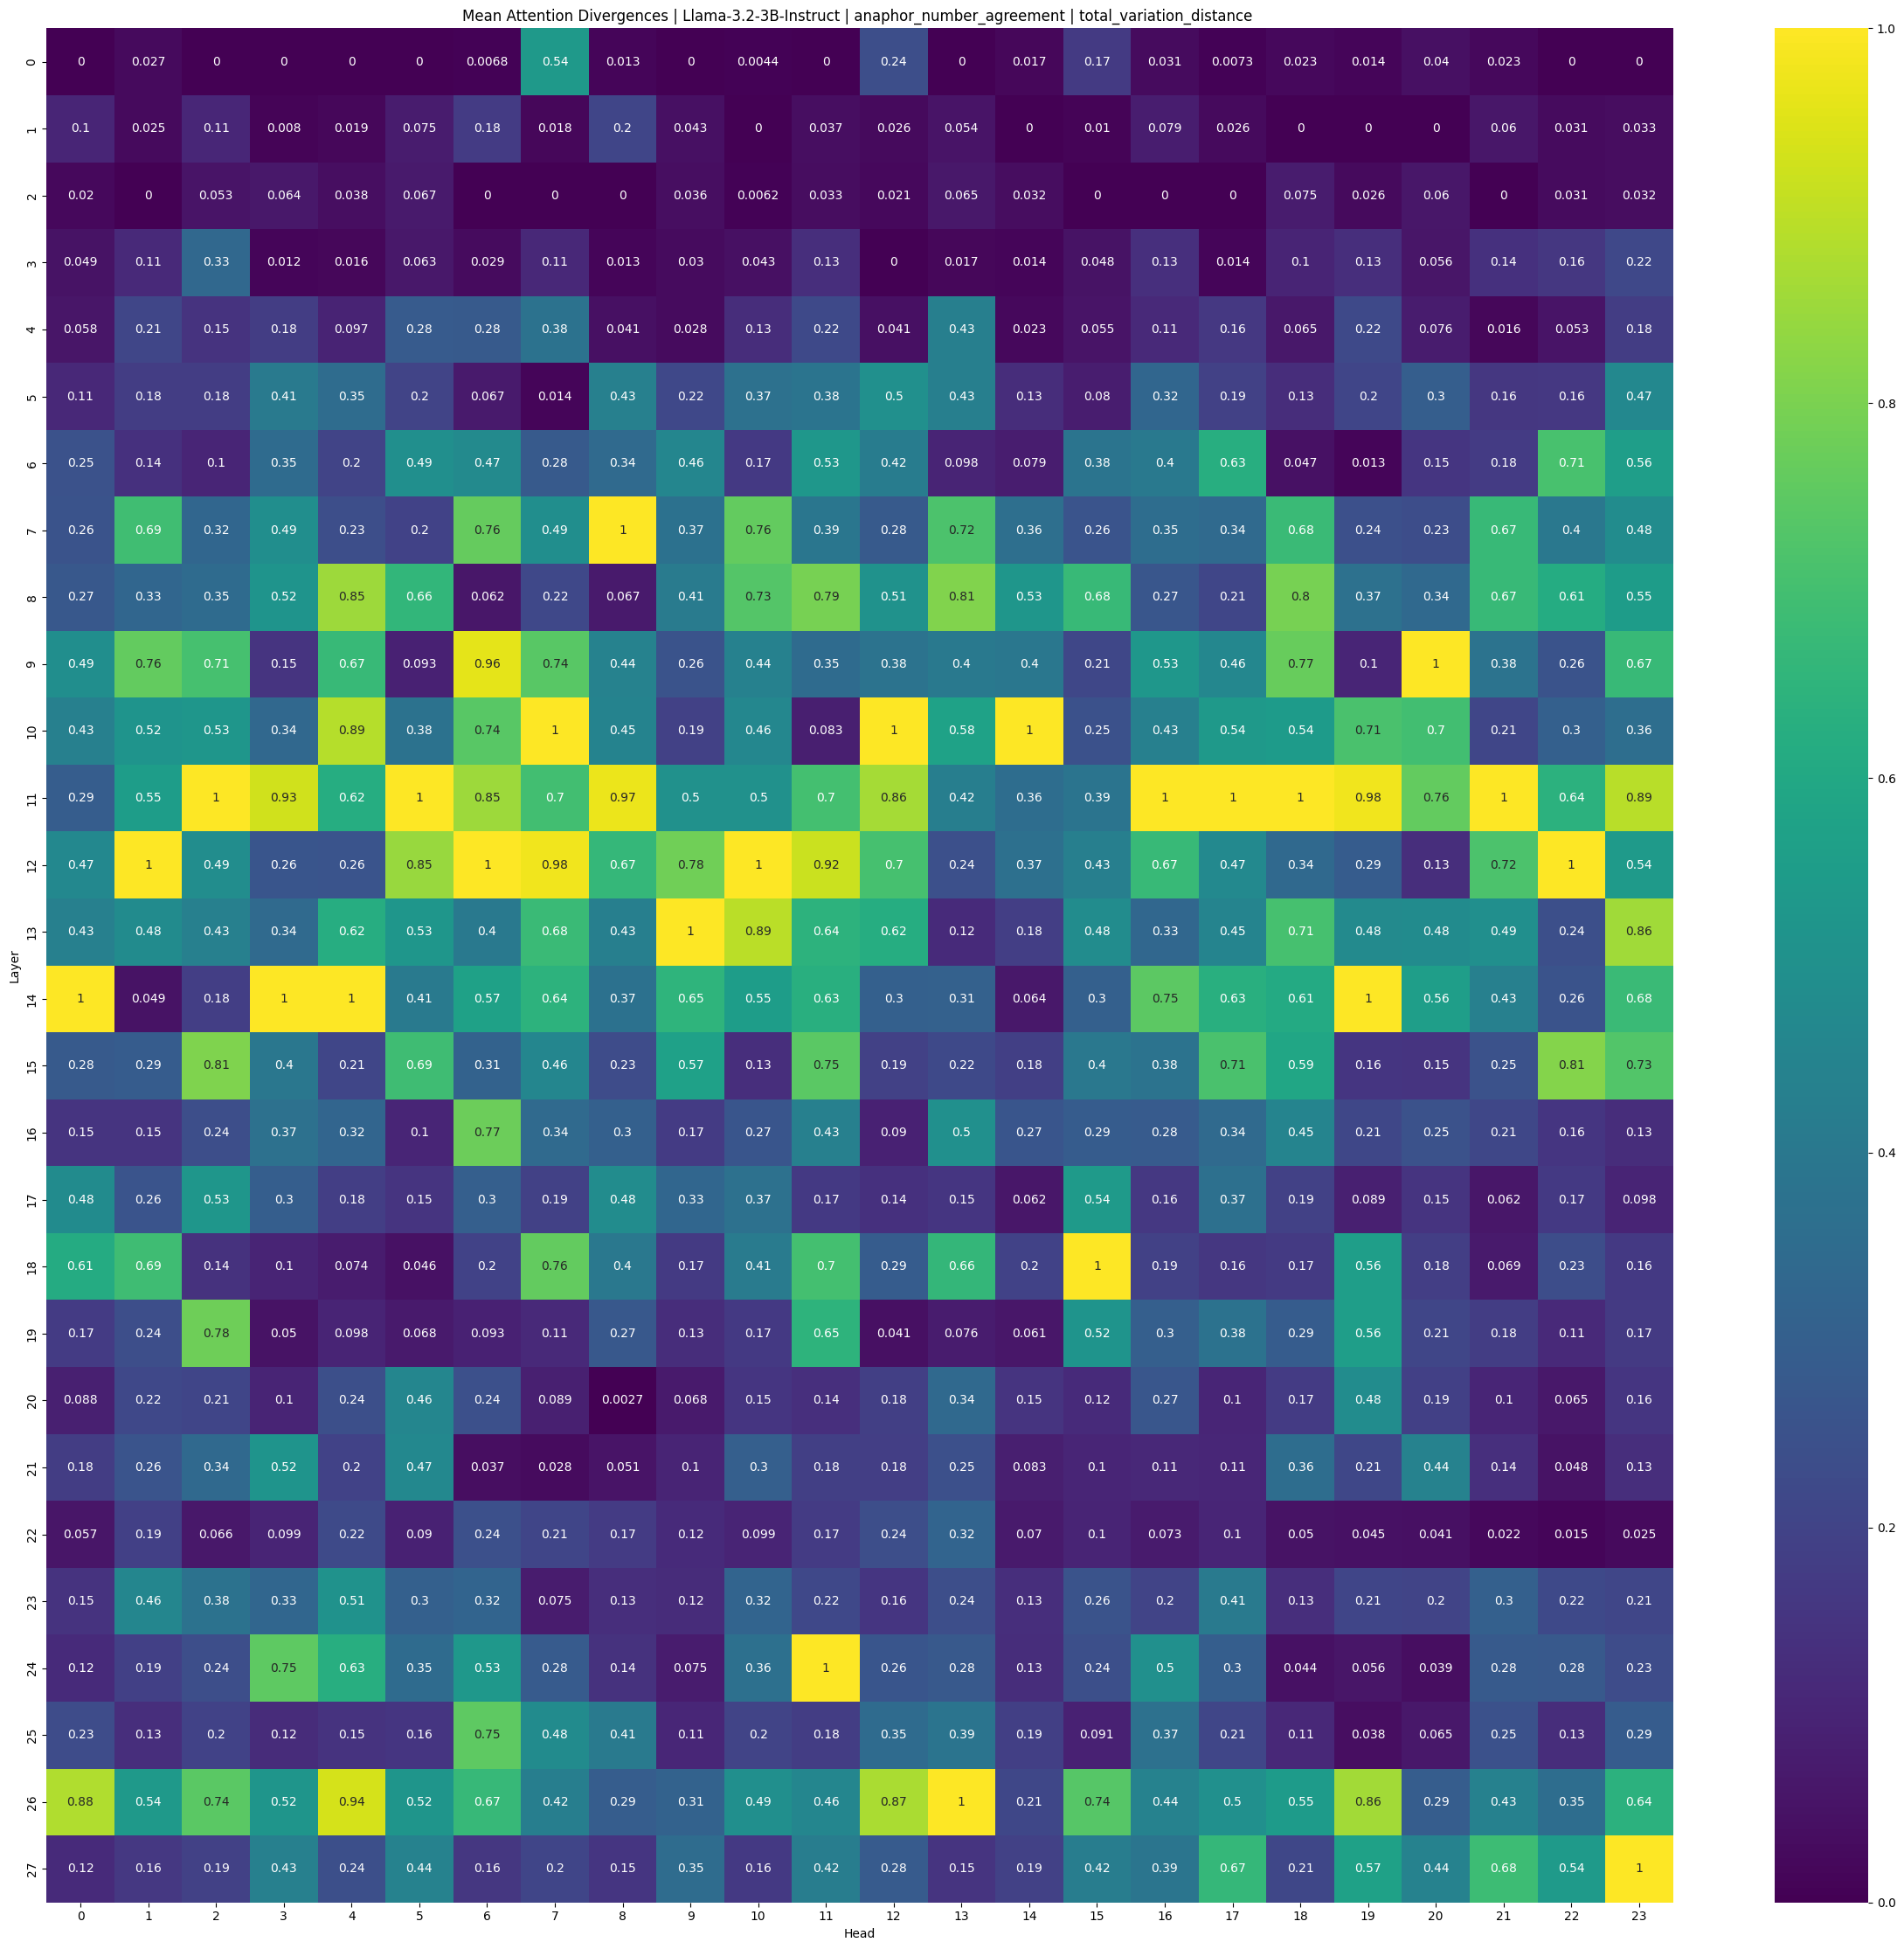

In [16]:
plot_attention_divergences('Llama-3.2-3B-Instruct', 'anaphor_number_agreement', dist_func=total_variation_distance, normalize=True)

1000it [00:06, 162.56it/s]


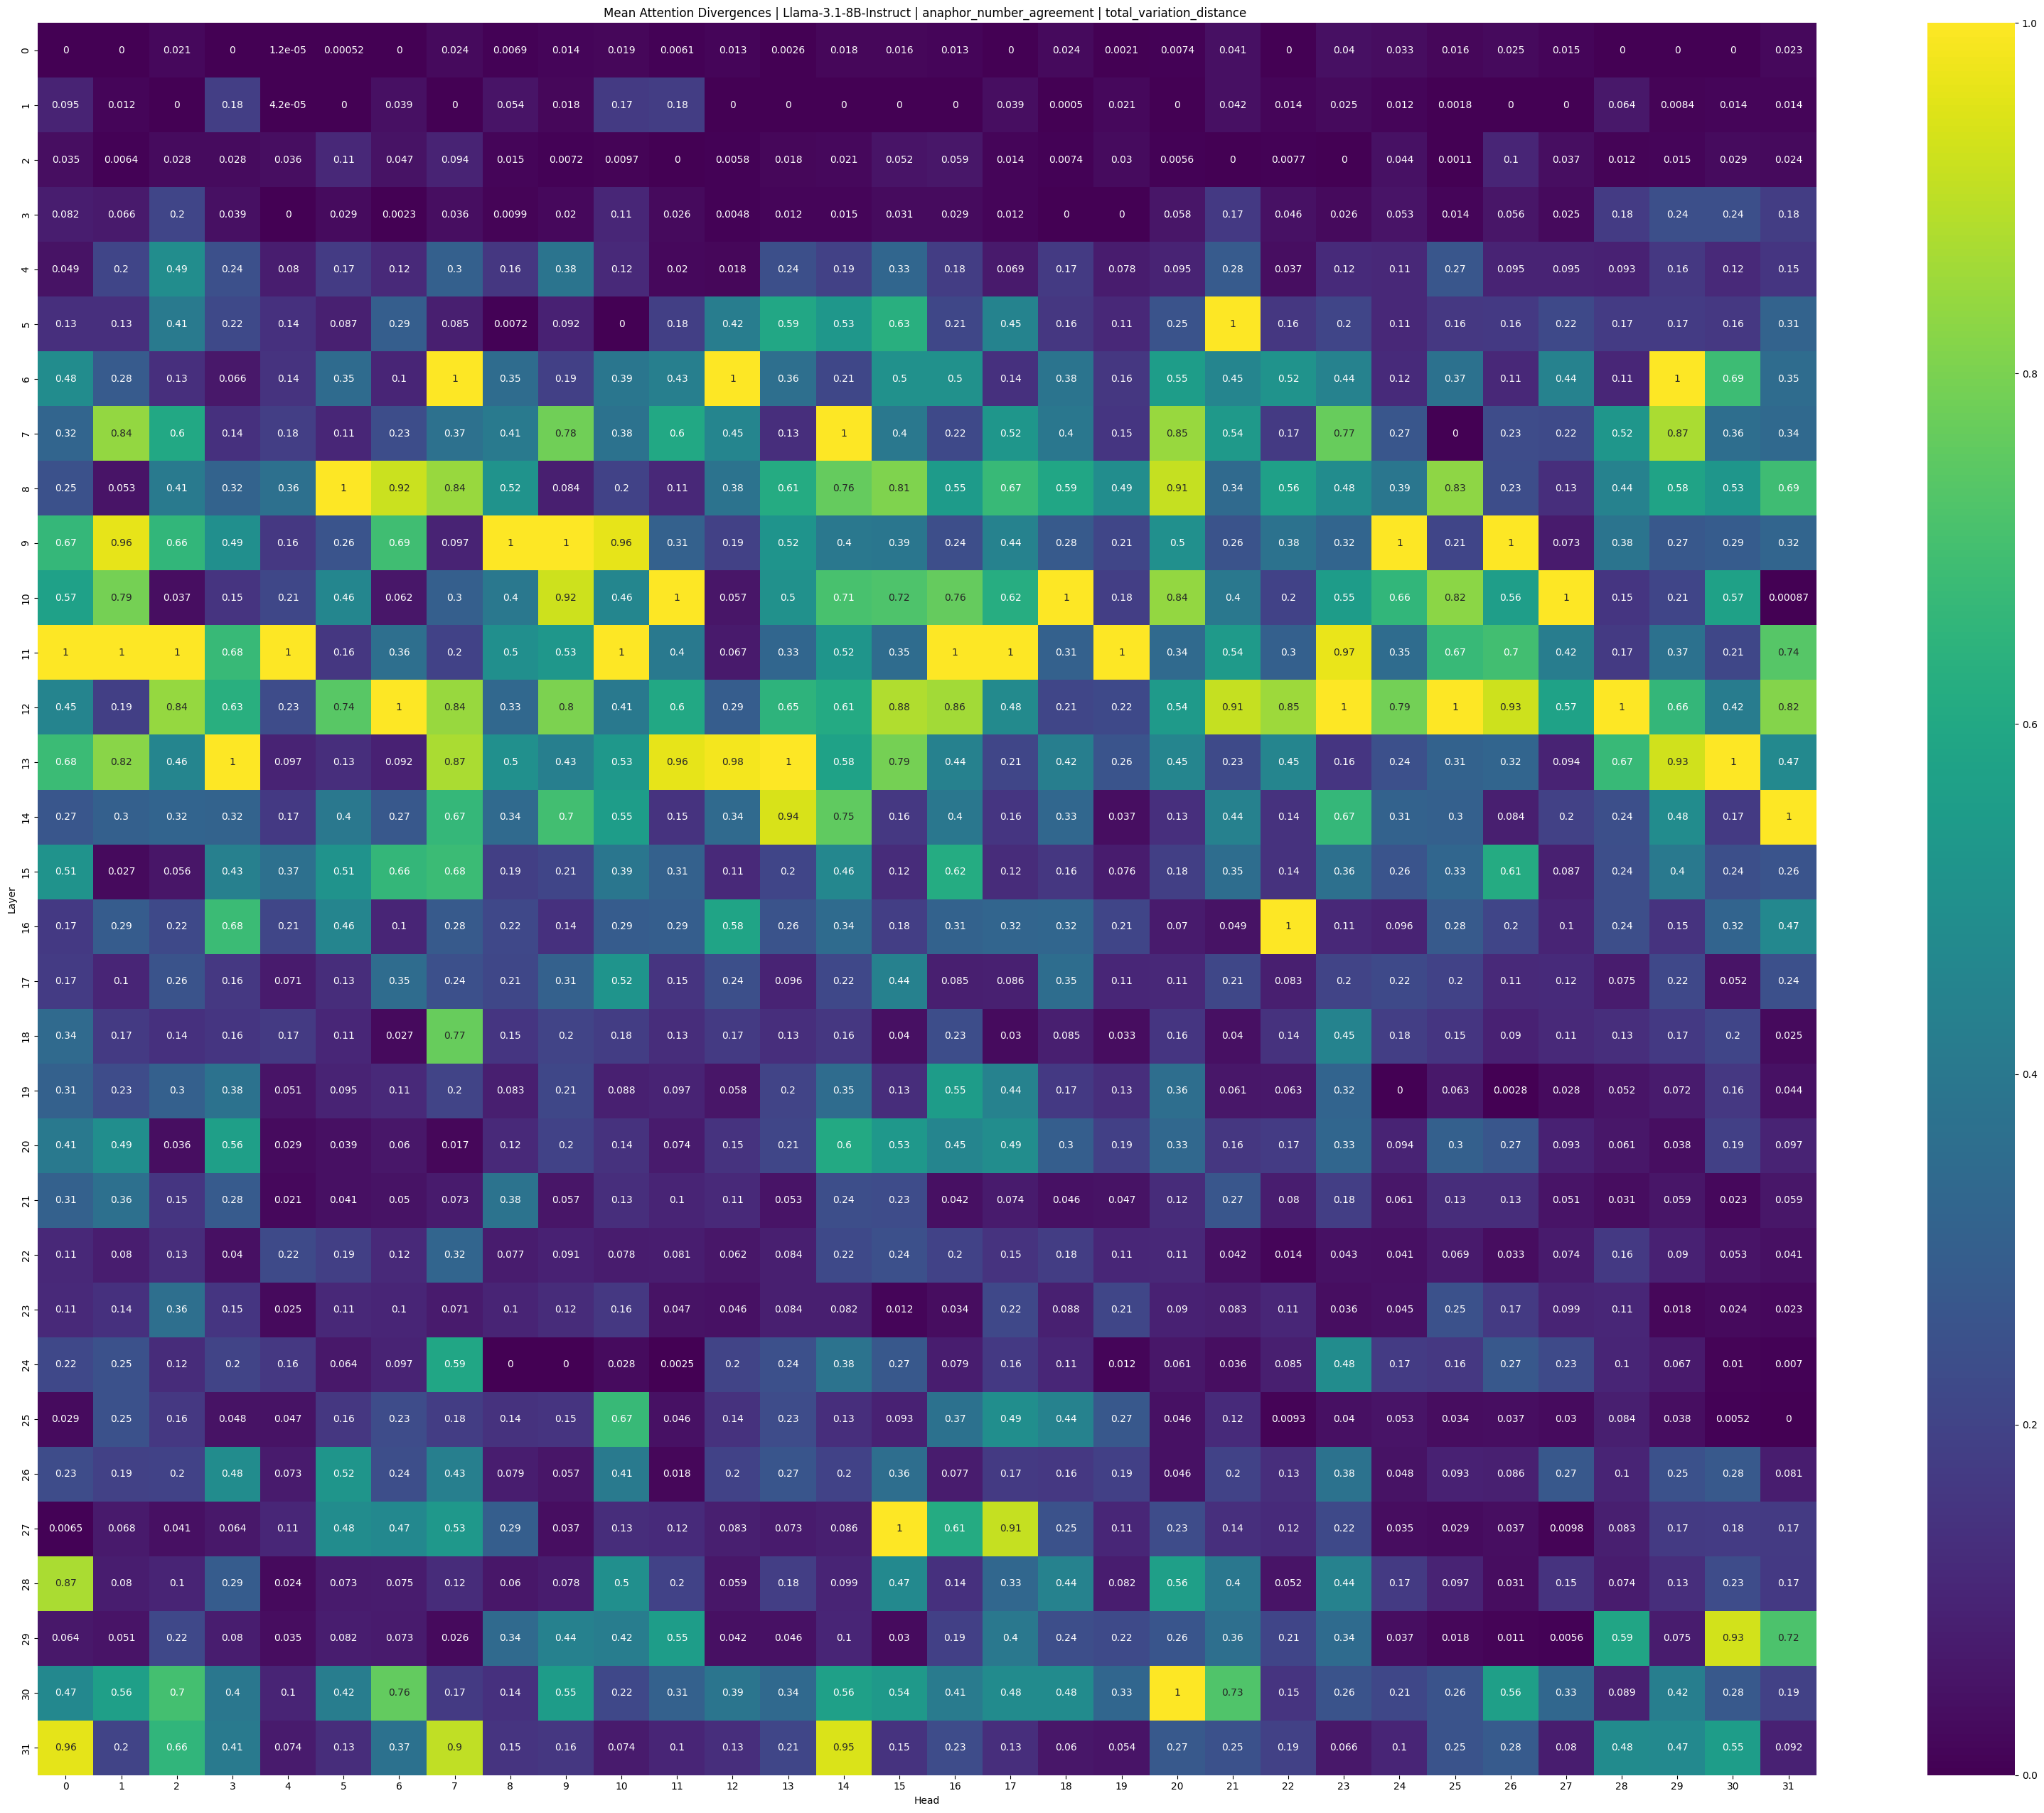

In [17]:
plot_attention_divergences('Llama-3.1-8B-Instruct', 'anaphor_number_agreement', dist_func=total_variation_distance, normalize=True)

1000it [00:10, 96.16it/s]


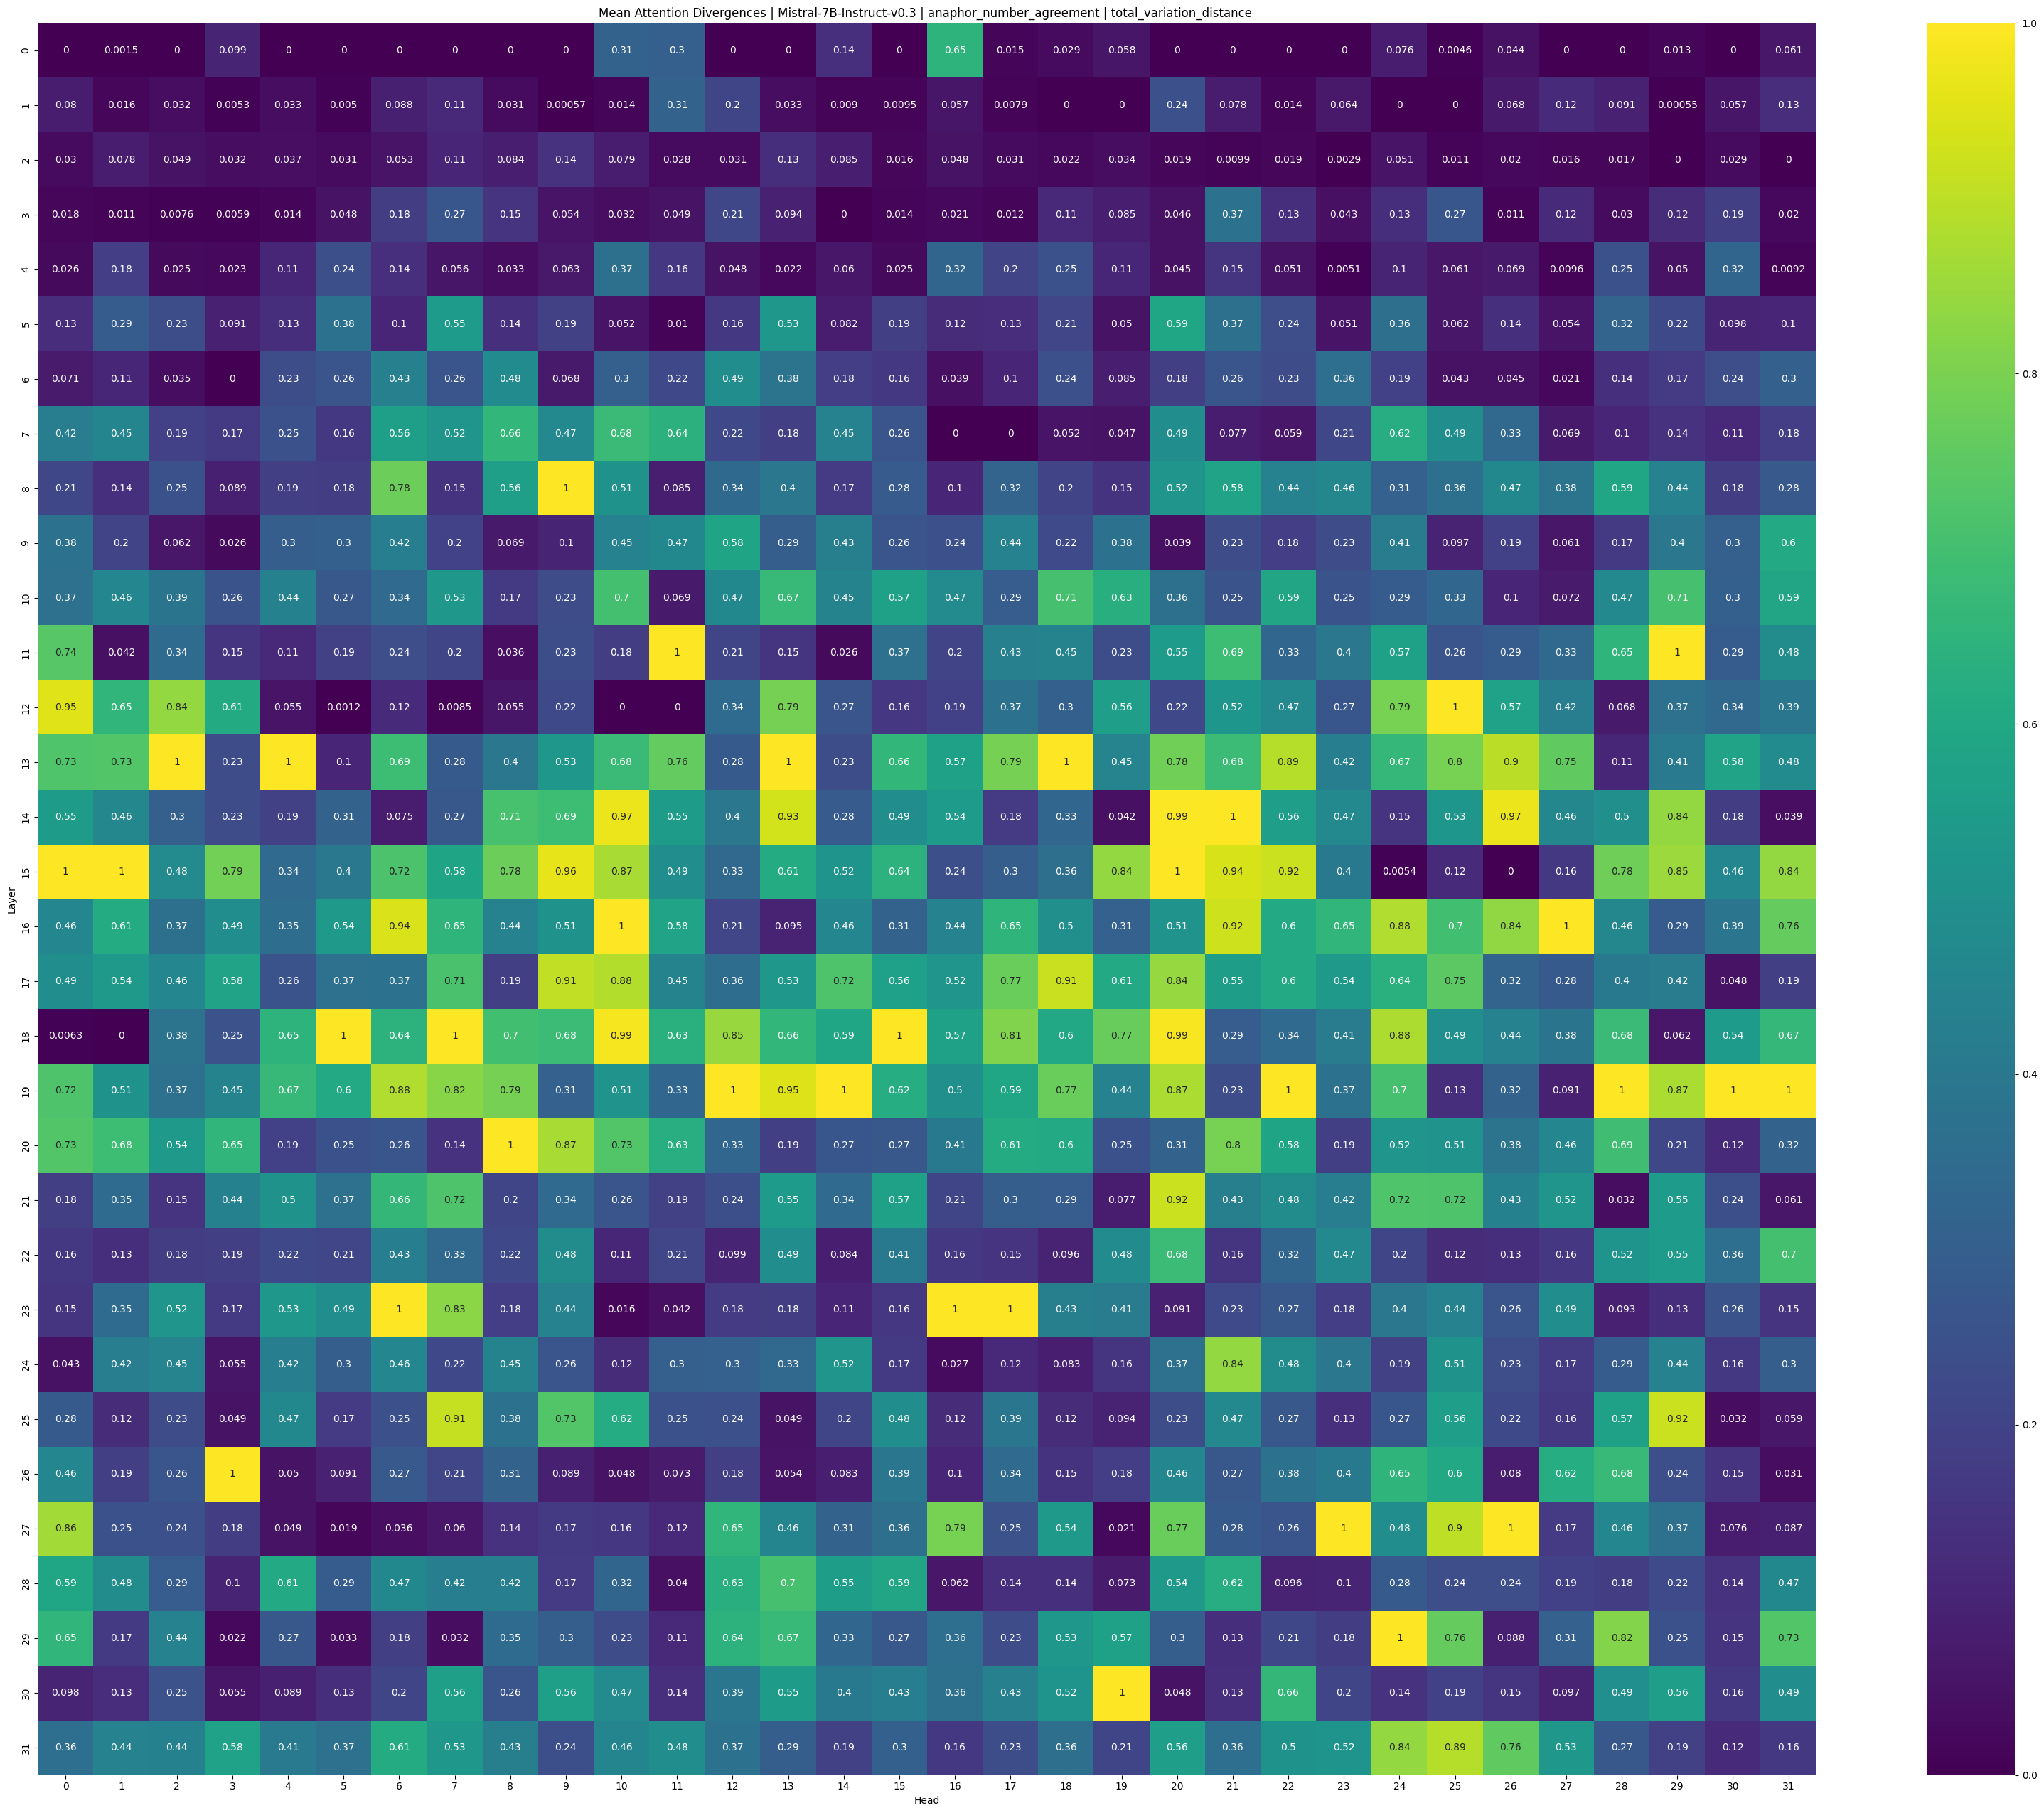

In [18]:
plot_attention_divergences('Mistral-7B-Instruct-v0.3', 'anaphor_number_agreement', dist_func=total_variation_distance, normalize=True)

1000it [00:03, 300.44it/s]


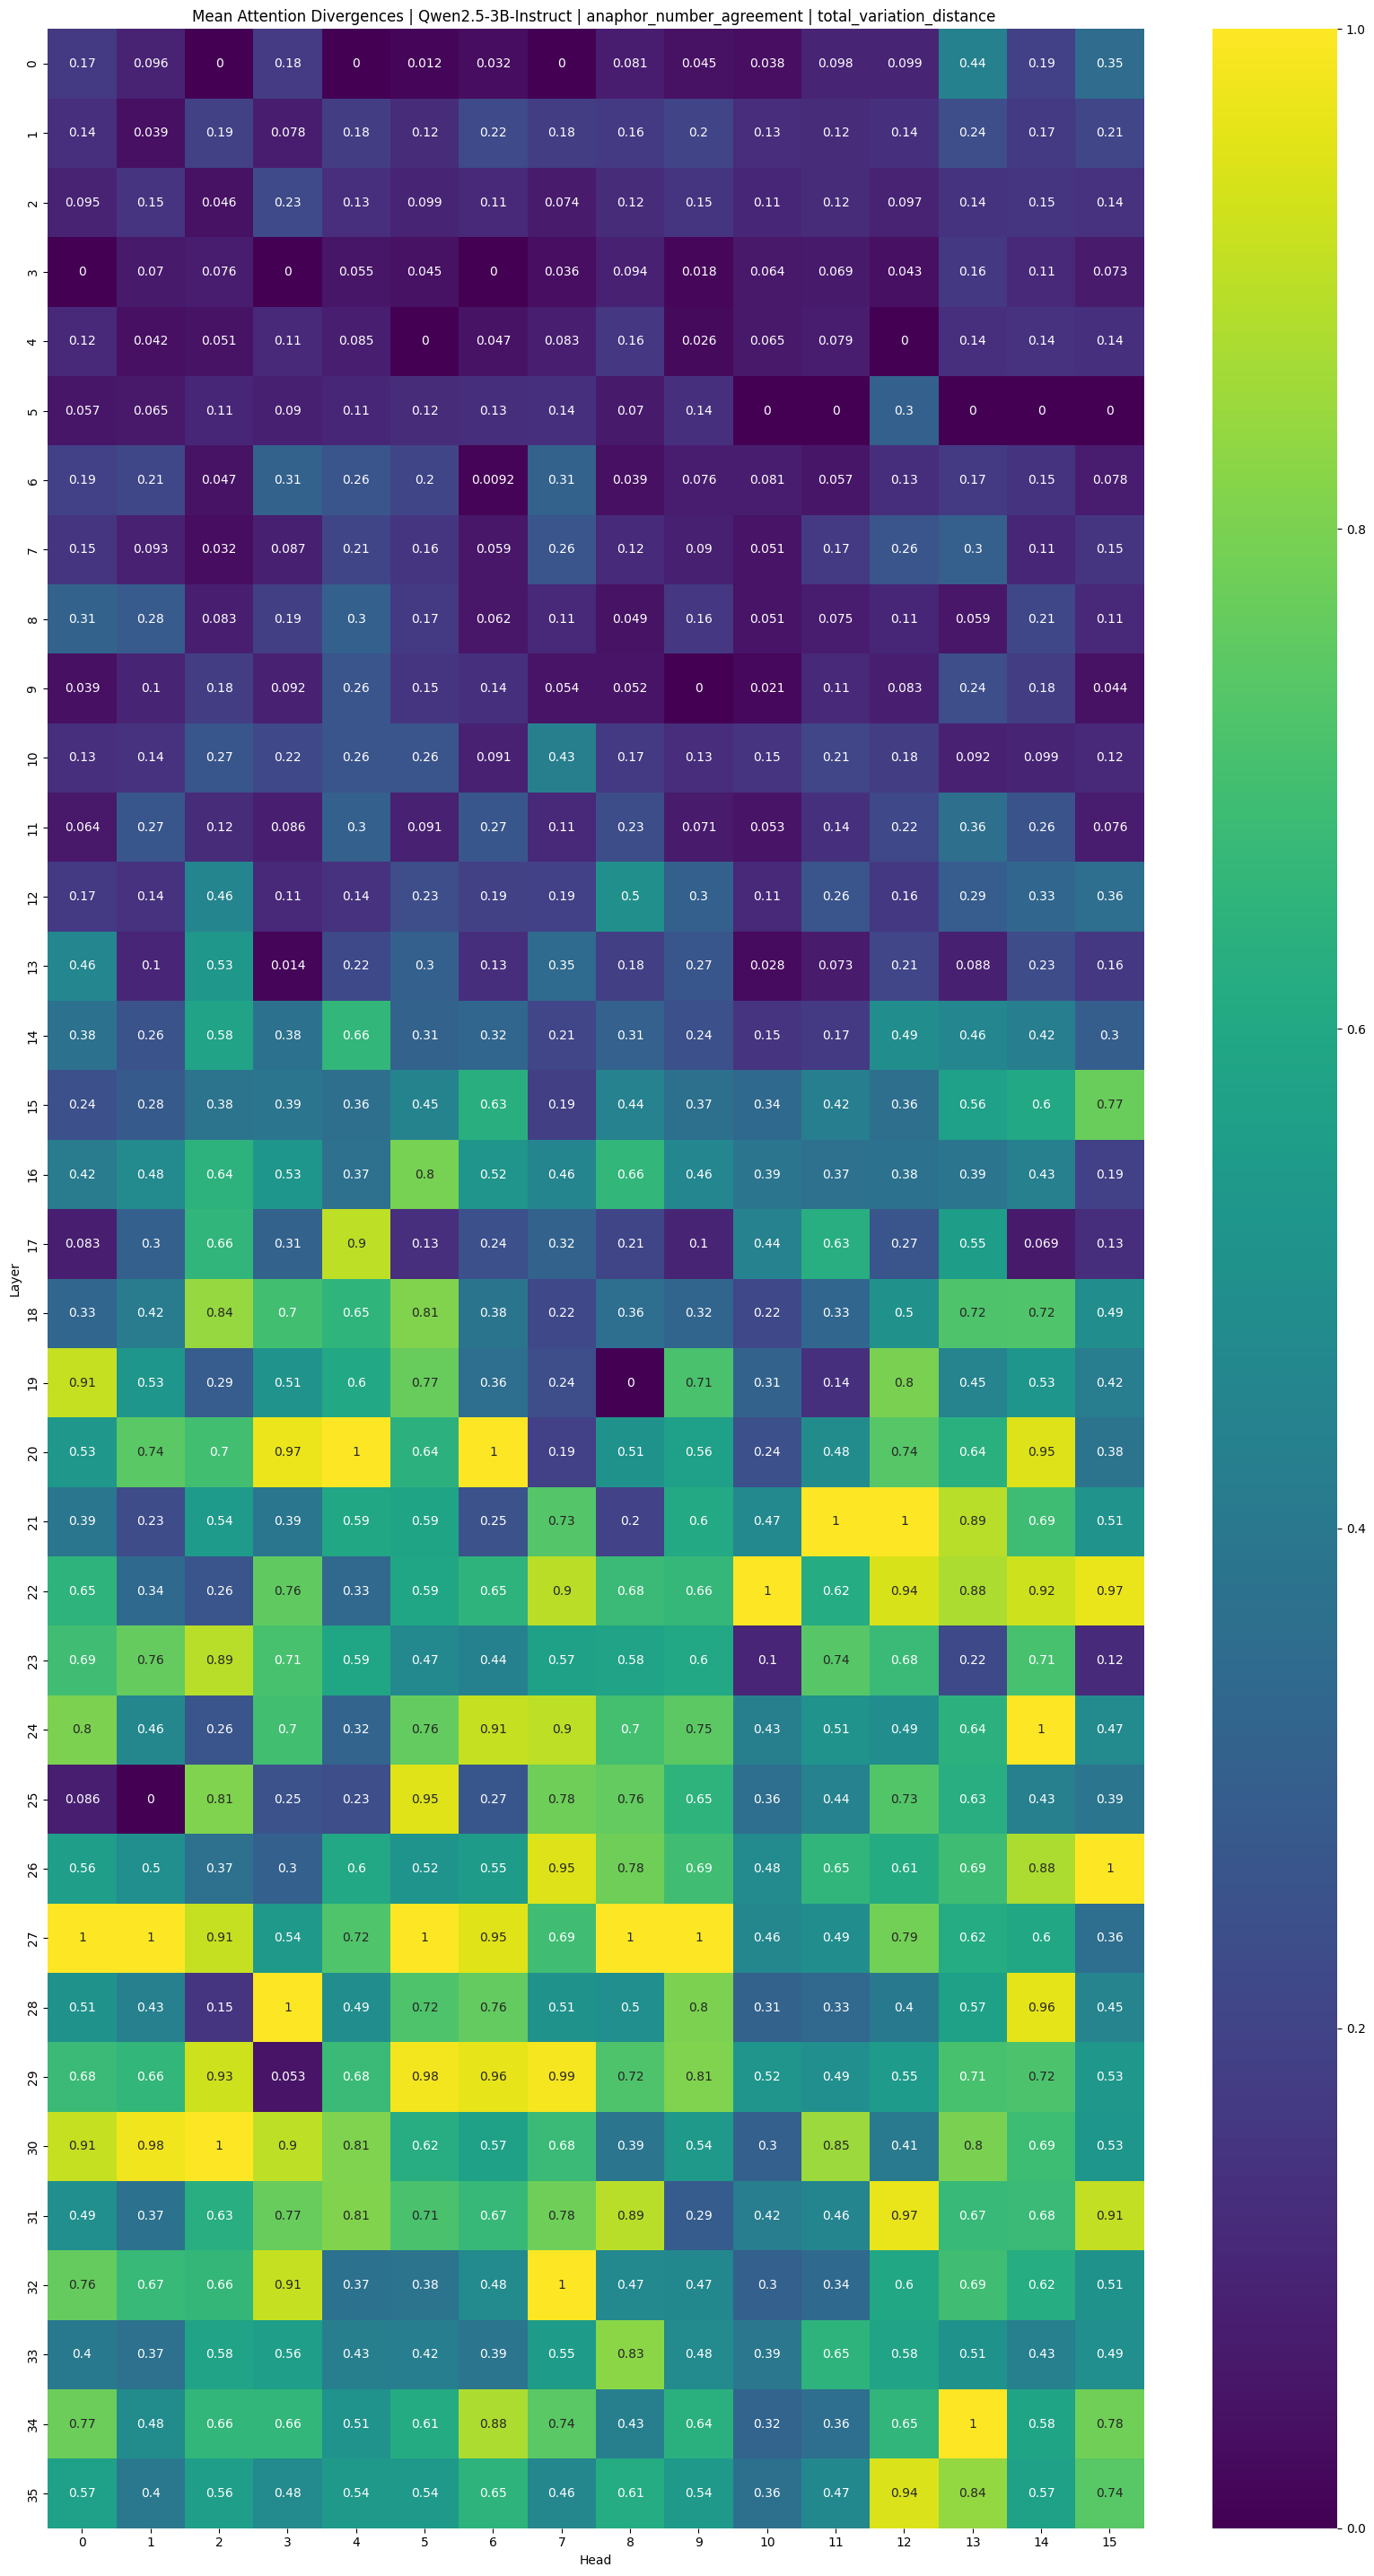

In [19]:
plot_attention_divergences('Qwen2.5-3B-Instruct', 'anaphor_number_agreement', dist_func=total_variation_distance, normalize=True)

1000it [00:04, 219.32it/s]


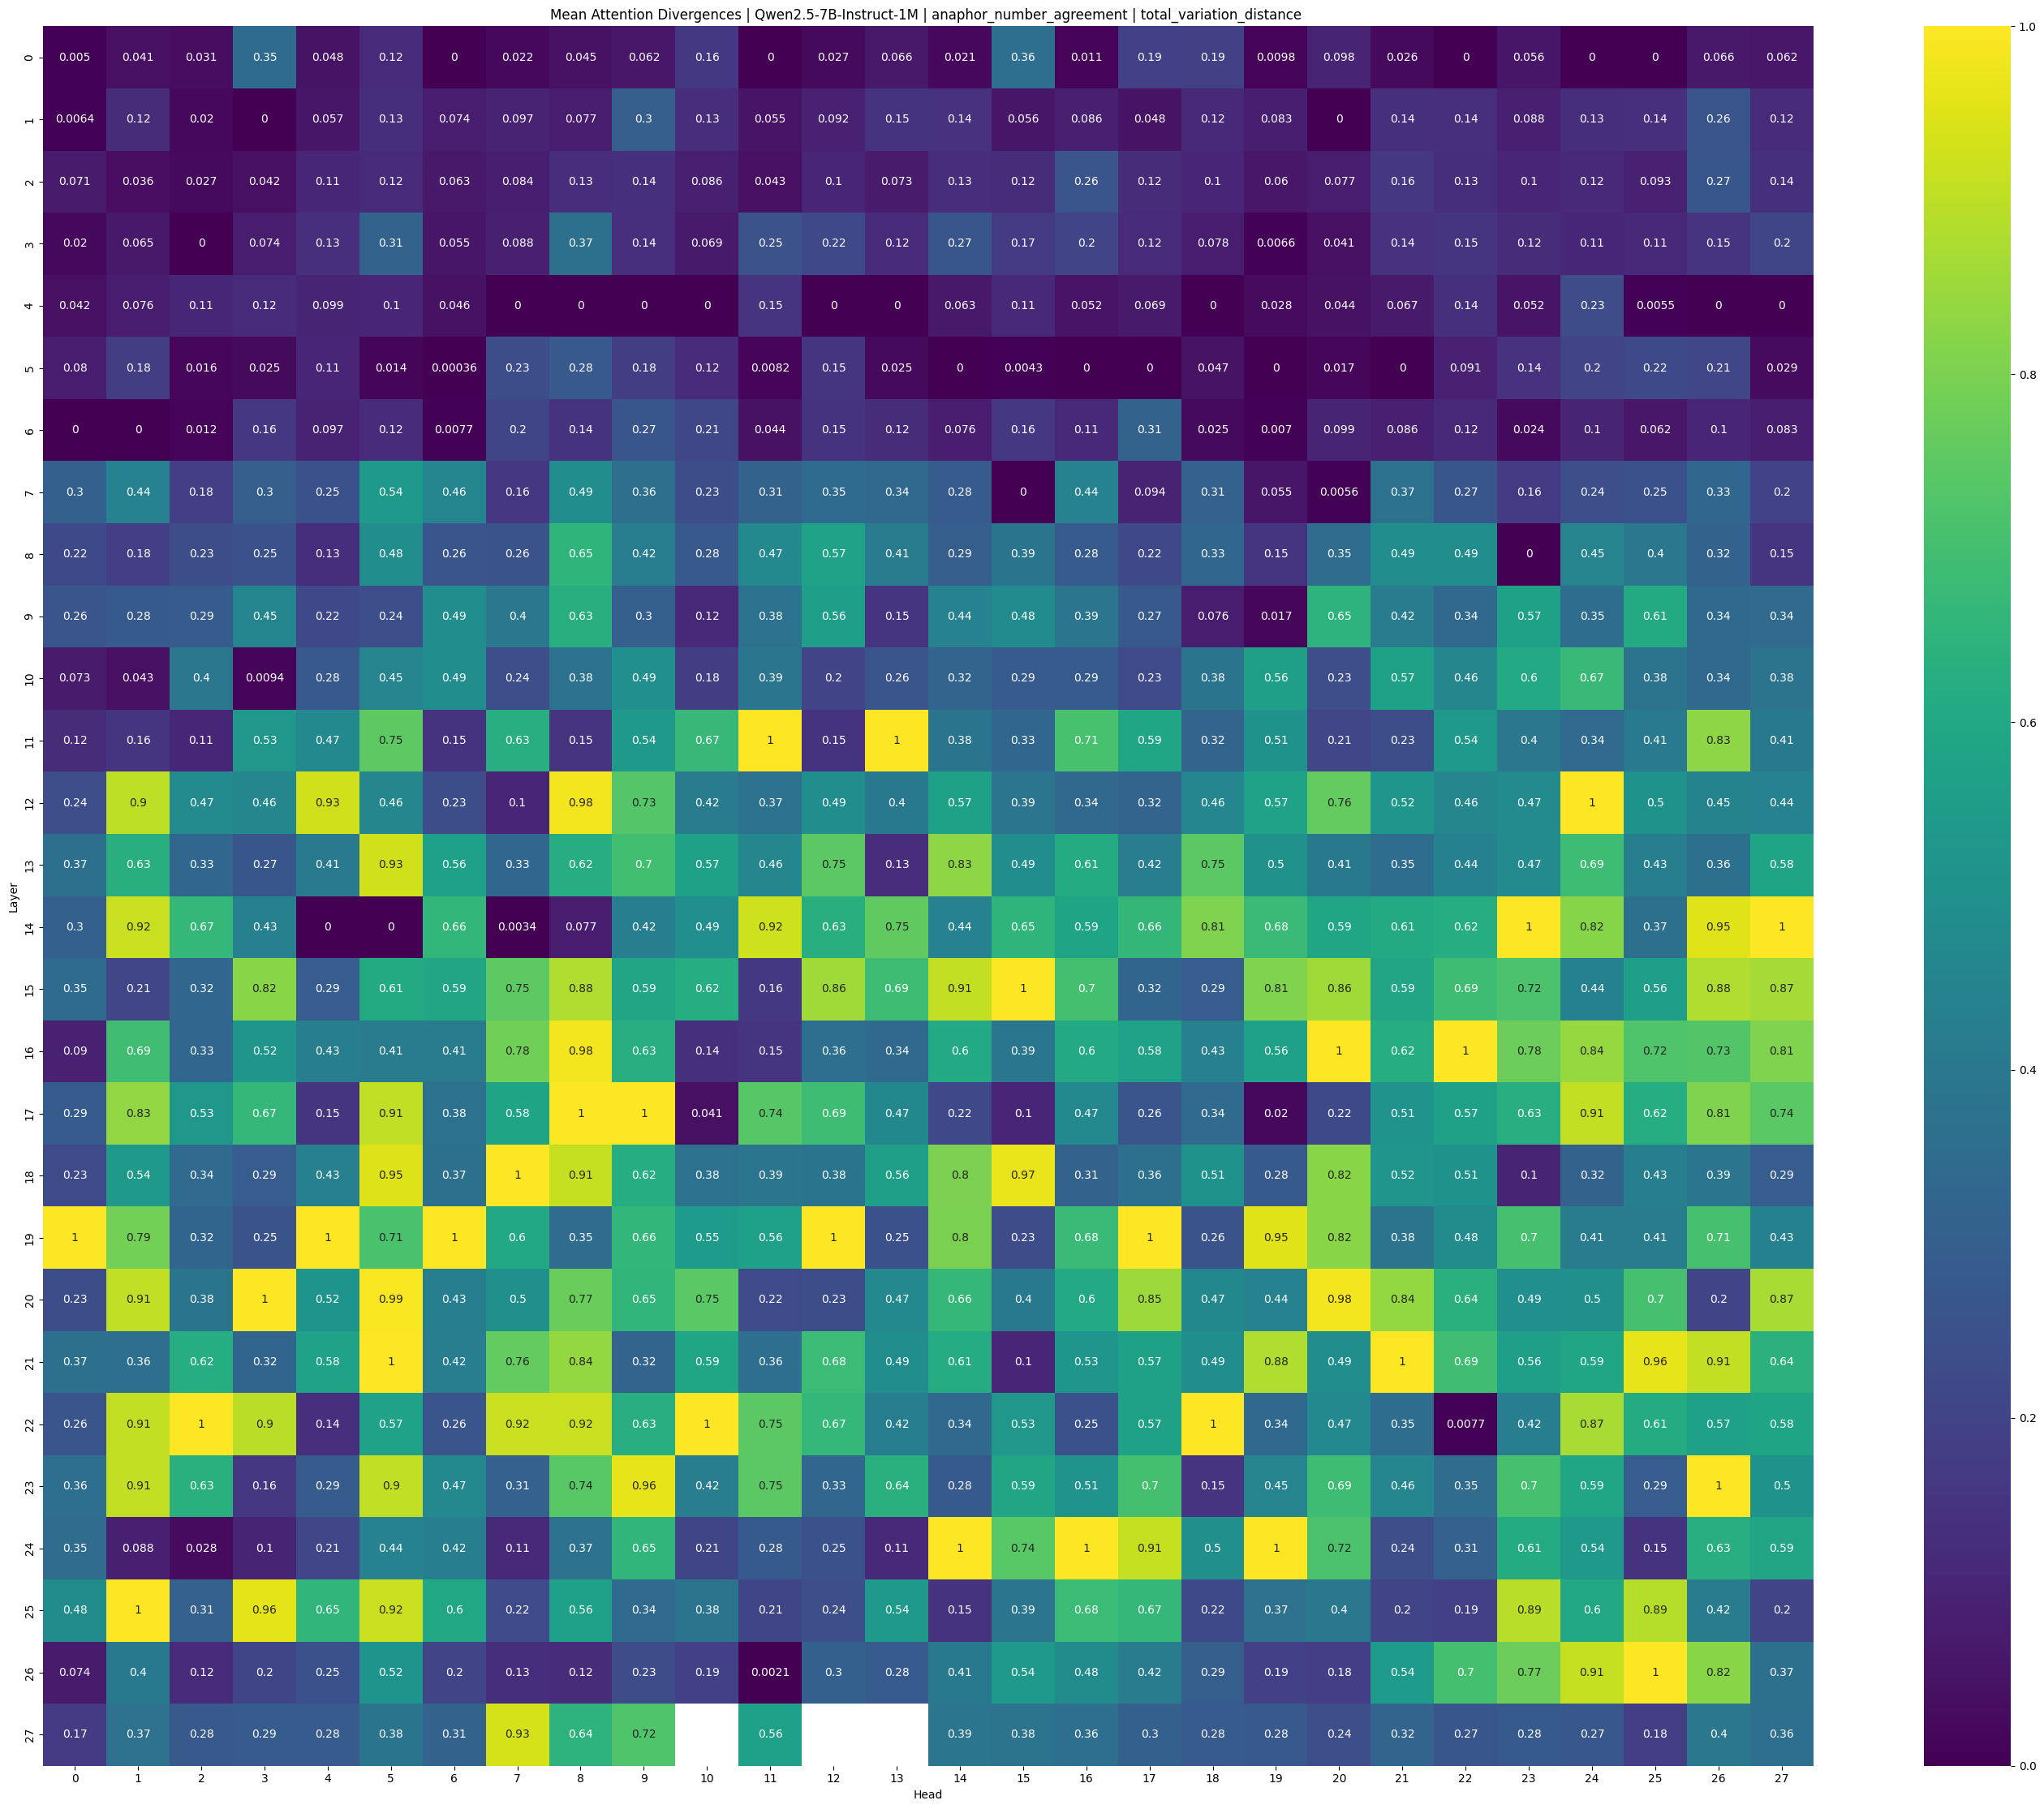

In [20]:
plot_attention_divergences('Qwen2.5-7B-Instruct-1M', 'anaphor_number_agreement', dist_func=total_variation_distance, normalize=True)